<a href="https://colab.research.google.com/github/PRAN20/Fingerprint-Recognition-Infant/blob/main/Fingerprint_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Header Files**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random

import os
import datetime

# **Importing DataSet**

In [ ]:
img_data = np.load('/content/x_real.npy')
label_data = np.load('/content/y_real.npy')
img_real = np.load('/content/x_easy.npy')
label_real = np.load('/content/y_easy.npy')

In [ ]:
print(img_data.shape)

(800, 160, 160, 1)


In [ ]:
print(label_data.shape)

(800, 1)


In [ ]:
print(img_real.shape)

(10, 160, 160, 1)


In [ ]:
print(label_real.shape)

(10, 1)


# **Histogram Stretch**

In [ ]:
def hist_stretch(img_buf, width, height, shift):
    tmp1 = 0
    tmp2 = 0
    w_pHistBuf = np.zeros(256, dtype=np.uint32)
    total = 0
    ret_buf = np.zeros((width, height, 1), dtype=np.uint8)

    for i in range(height):
        for j in range(width):
            total = total + img_buf[i][j][0]
            w_pHistBuf[img_buf[i][j][0]] += 1
    diff = (int)(shift - (total / (width * height)))
    w_pHistBuf = np.zeros(256, dtype=np.uint32)

    for i in range(height):
        for j in range(width):
            tmp = img_buf[i][j][0] + diff
            if (tmp > 255):
                tmp = 255
            elif (tmp < 0):
                tmp = 0
            ret_buf[i][j][0] = tmp
            w_pHistBuf[tmp] += 1

    for i in range(256):
        if (w_pHistBuf[i] != 0):
            tmp1 = i
            break
    for i in range(255, 0, -1):
        if (w_pHistBuf[i] != 0):
            tmp2 = i
            break
    for i in range(height):
        for j in range(width):
            ret_buf[i][j][0] = (int)((255 * (ret_buf[i][j][0] - tmp1) / (tmp2 - tmp1)))
    
    return ret_buf

for i in range(img_data.shape[0]):
    img_tmp = hist_stretch(img_data[i], 160, 160, 128)
    img_data[i] = img_tmp
    
for i in range(img_real.shape[0]):
    img_tmp = hist_stretch(img_real[i], 160, 160, 128)
    img_real[i] = img_tmp

# **Train-Test Split**

In [ ]:
img_train, img_val, label_train, label_val = train_test_split(img_data, label_data, test_size = 0.1)
print(img_data.shape, label_data.shape)
print(img_train.shape, label_train.shape)
print(img_val.shape, label_val.shape)

(800, 160, 160, 1) (800, 1)
(720, 160, 160, 1) (720, 1)
(80, 160, 160, 1) (80, 1)


# **Build Model**

In [ ]:
def build_model():
    x1 = layers.Input(shape = (160, 160, 1))
    x2 = layers.Input(shape = (160, 160, 1))

    inputs = layers.Input(shape = (160, 160, 1))
    feature = layers.Conv2D(32, kernel_size = 3, activation = 'relu')(inputs)
    feature = layers.MaxPooling2D(pool_size = 2)(feature)
    feature = layers.Conv2D(64, kernel_size = 3, activation = 'relu')(feature)
    feature = layers.MaxPooling2D(pool_size = 2)(feature)
    feature = layers.Conv2D(128, kernel_size = 3, activation = 'relu')(feature)
    feature = layers.MaxPooling2D(pool_size = 2)(feature)
    feature_model = Model(inputs = inputs, outputs = feature)

    feature_model.summary()

    x1_net = feature_model(x1)
    x2_net = feature_model(x2)

    net = layers.Subtract()([x1_net, x2_net])
    net = layers.Conv2D(128, kernel_size = 3, activation = 'relu')(net)
    net = layers.MaxPooling2D(pool_size = 2)(net)
    net = layers.Flatten()(net)
    net = layers.Dropout(0.3)(net)
    net = layers.Dense(512, activation = 'relu')(net)
    net = layers.Dense(1, activation = 'sigmoid')(net)
    model = Model(inputs = [x1, x2], outputs = net)

    model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4), metrics = ['acc'])

    model.summary()

    return (model, feature_model)

# **Data Degenerator**

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, img_data, label_data, img_real, label_real, batch_size = 32, shuffle = True):
        self.img_data = img_data
        self.label_data = label_data
        self.img_real = img_real
        self.label_real = label_real
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.img_data) / self.batch_size) * 2)

    def __getitem__(self, index):
        real_idx = index
        index = int(np.floor(index / 2))
        img1_batch = self.img_data[index * self.batch_size : (index + 1) * self.batch_size]
        label1_batch = self.label_data[index * self.batch_size : (index + 1) * self.batch_size]
        img2_batch = np.empty((self.batch_size, 160, 160, 1), dtype = np.float32)
        label2_batch = np.zeros((self.batch_size, 1), dtype = np.float32)

        for i, idx in enumerate(label1_batch):
            if random.random() > 0.5:
                img2_batch[i] = self.img_real[idx]
                label2_batch[i] = 1.
            else:
                while True:
                    unmatch_idx = random.choice(list(self.label_real))
                    if (unmatch_idx != idx):
                        break

                img2_batch[i] = self.img_real[unmatch_idx]
                label2_batch[i] = 0.
                
        index = real_idx
        if (index < int(np.floor(len(self.img_data) / self.batch_size))):
            return [img1_batch.astype(np.float32) / 255., img2_batch.astype(np.float32) / 255.], label2_batch
        
        return [img2_batch.astype(np.float32) / 255., img1_batch.astype(np.float32) / 255.], label2_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.img_data, self.label_data = shuffle(self.img_data, self.label_data)

# **Prepare Generator**

In [ ]:
train_gen = DataGenerator(img_train, label_train, img_real, label_real, shuffle = True)
val_gen = DataGenerator(img_val, label_val, img_real, label_real, shuffle = True)

# **CheckPoint**

In [ ]:
!unzip "/content/drive/MyDrive/results.zip" -d "Local"

Archive:  /content/drive/MyDrive/results.zip
  inflating: Local/__results___files/__results___24_0.png  
  inflating: Local/__results___files/__results___24_1.png  
  inflating: Local/__results___files/__results___28_1.png  
  inflating: Local/logs/train/20200413-153740/train/events.out.tfevents.1586792263.f502d6f0187b.13.410.v2  
  inflating: Local/logs/train/20200413-153740/train/events.out.tfevents.1586792268.f502d6f0187b.profile-empty  
  inflating: Local/logs/train/20200413-153740/train/plugins/profile/2020-04-13_15-37-48/local.trace  
  inflating: Local/logs/train/20200413-153740/validation/events.out.tfevents.1586792270.f502d6f0187b.13.2160.v2  
  inflating: Local/model/checkpoint/checkpoint  
  inflating: Local/model/checkpoint/cp.ckpt.data-00000-of-00002  
  inflating: Local/model/checkpoint/cp.ckpt.data-00001-of-00002  
  inflating: Local/model/checkpoint/cp.ckpt.index  
  inflating: Local/model/fp160.h5    
  inflating: Local/model/fp160_feature.h5  


In [ ]:
checkpoint_path = '/content/Local/model/checkpoint/cp.ckpt.index'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, save_weights_only = True, verbose = 1)

In [ ]:
checkpoint_path

'/content/Local/model/checkpoint/cp.ckpt.index'

# **TensorBoard**

In [ ]:
tfb_log_dir = '/content/Local/logs/train' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = tfb_log_dir, histogram_freq = 1)

# **Preapare Training**

In [ ]:
(model, feature_model) = build_model()
if (os.path.exists(checkpoint_path + '.index')):
    print('continue training')
    model.load_weights(checkpoint_path)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 158, 158, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 128)       73856 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


# **Training**

In [ ]:
history = model.fit(train_gen, epochs = 100, validation_data = val_gen, callbacks = [cp_callback, tensorboard_callback])

Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 0.6890 - acc: 0.5249
Epoch 1: saving model to /content/Local/model/checkpoint/cp.ckpt.index
44/44 [==============================] - 19s 150ms/step - loss: 0.6890 - acc: 0.5249 - val_loss: 0.6761 - val_acc: 0.5312
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 0.6361 - acc: 0.6300
Epoch 2: saving model to /content/Local/model/checkpoint/cp.ckpt.index
44/44 [==============================] - 6s 136ms/step - loss: 0.6361 - acc: 0.6300 - val_loss: 0.5993 - val_acc: 0.7422
Epoch 3/100
44/44 [==============================] - ETA: 0s - loss: 0.6043 - acc: 0.6634
Epoch 3: saving model to /content/Local/model/checkpoint/cp.ckpt.index
44/44 [==============================] - 6s 137ms/step - loss: 0.6043 - acc: 0.6634 - val_loss: 0.6380 - val_acc: 0.6406
Epoch 4/100
44/44 [==============================] - ETA: 0s - loss: 0.6007 - acc: 0.6697
Epoch 4: saving model to /content/Local/model/checkpoint/cp.ckp

# **Results**

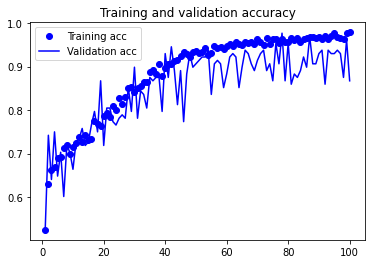

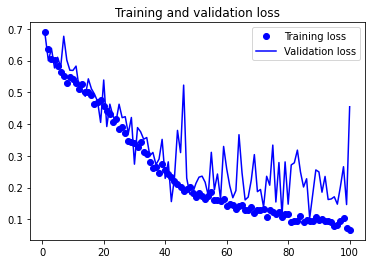

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Saving the Model**

In [ ]:
model_path = '/content/Local/model/fp160.h5'
model_feature_path = '/content/Local/model/fp160_feature.h5'
model.save(model_path)
feature_model.save(model_feature_path)